In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats

In [31]:
df = pd.read_csv('DataSet0.csv')

In [32]:
print("Dataset Shape:", df.shape)
df.info()
df.describe()

Dataset Shape: (600, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   weekend_date  600 non-null    object
 1   channel       600 non-null    object
 2   brand         600 non-null    object
 3   category      600 non-null    object
 4   sub_category  600 non-null    object
 5   SerailNum     600 non-null    int64 
 6   quantity      600 non-null    int64 
dtypes: int64(2), object(5)
memory usage: 32.9+ KB


,SerailNum,quantity
count,600.000000,600.000000
mean,3.048333,547.330000
std,1.399737,925.749108
min,1.000000,1.000000
25%,2.000000,121.000000
50%,3.000000,244.500000
75%,4.000000,624.500000
max,5.000000,8051.000000


In [36]:
# Check for missing values
print("Missing values:\n", df.isnull().sum())

Missing values:
 weekend_date    0
channel         0
brand           0
category        0
sub_category    0
SerailNum       0
quantity        0
dtype: int64


In [37]:
# Check for duplicate records
print("Duplicates:", df.duplicated().sum())

Duplicates: 0


In [43]:
df['weekend_date'] = pd.to_datetime(df['weekend_date'], dayfirst=True, format='mixed')

In [44]:
print(df['weekend_date'].head())
print(df['weekend_date'].dtype)

0   2022-06-04
1   2022-06-11
2   2022-06-18
3   2022-06-25
4   2022-07-02
Name: weekend_date, dtype: datetime64[ns]
datetime64[ns]


In [45]:
df['weekend_date'] = df['weekend_date'].dt.date

In [48]:
df.set_index('weekend_date', inplace=True)

In [61]:
print(df.dtypes)
print(df.index)

channel         object
brand           object
category        object
sub_category    object
SerailNum        int64
quantity         int64
dtype: object
DatetimeIndex(['2022-06-04', '2022-06-11', '2022-06-18', '2022-06-25',
               '2022-07-02', '2022-07-09', '2022-07-16', '2022-07-23',
               '2022-07-30', '2022-08-06',
               ...
               '2024-08-10', '2024-08-17', '2024-08-17', '2024-08-17',
               '2024-08-24', '2024-08-24', '2024-08-24', '2024-08-31',
               '2024-08-31', '2024-08-31'],
              dtype='datetime64[ns]', name='weekend_date', length=600, freq=None)


In [57]:
df.index = pd.to_datetime(df.index)

In [58]:
# Now resample weekly
weekly_sales = df['quantity'].resample('W').sum()

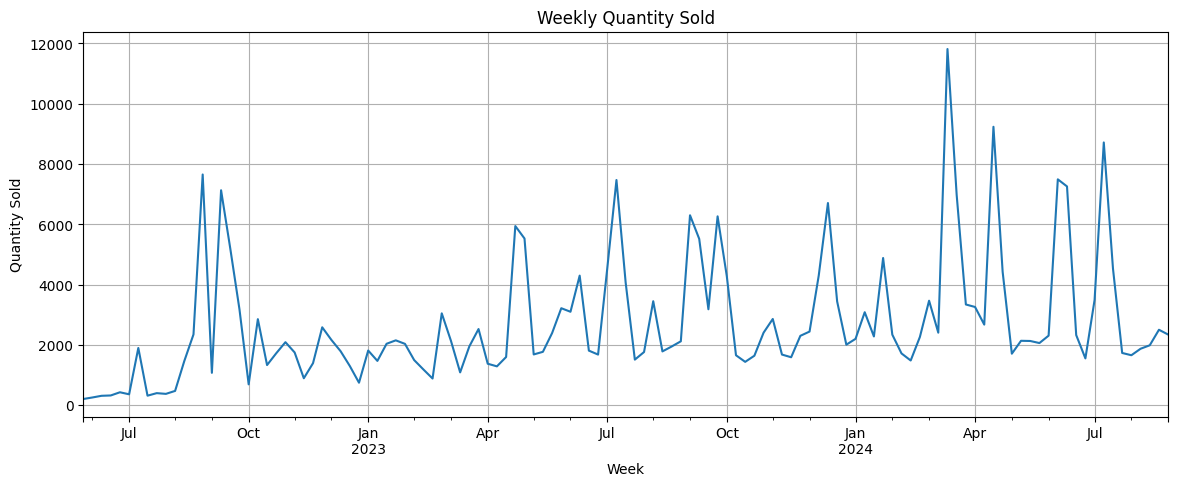

In [59]:
weekly_sales.plot(figsize=(14, 5), title='Weekly Quantity Sold')
plt.xlabel("Week")
plt.ylabel("Quantity Sold")
plt.grid(True)
plt.show()

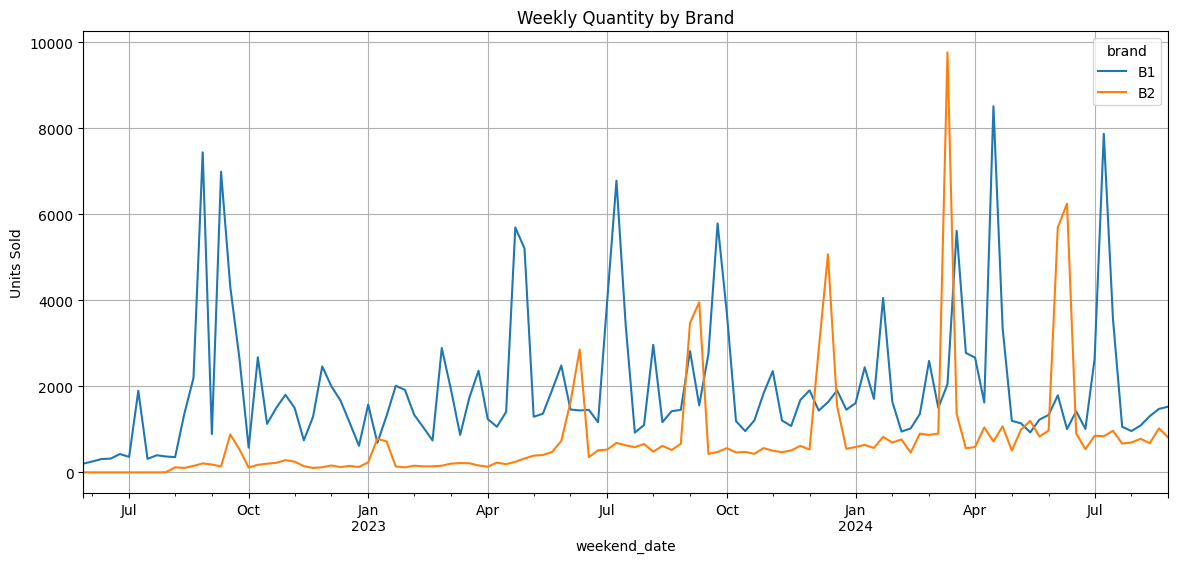

In [62]:
weekly_by_brand = df.groupby([pd.Grouper(freq='W'), 'brand'])['quantity'].sum().unstack().fillna(0)

weekly_by_brand.plot(figsize=(14, 6), title='Weekly Quantity by Brand')
plt.ylabel("Units Sold")
plt.grid(True)
plt.show()

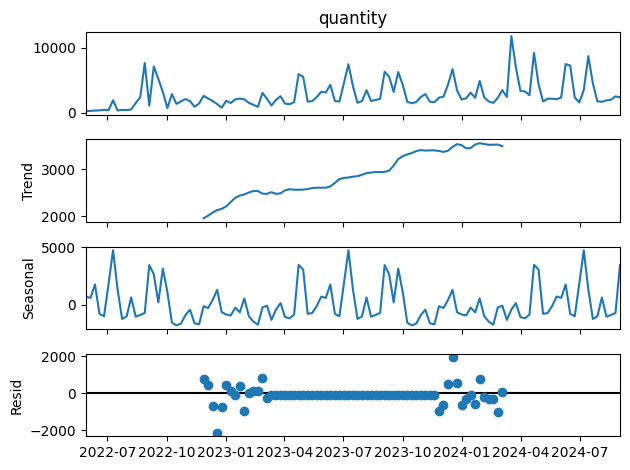

In [63]:
# Run decomposition (weekly data, assume 52-week seasonality)
decompose_result = seasonal_decompose(weekly_sales, model='additive', period=52)
decompose_result.plot()
plt.tight_layout()
plt.show()

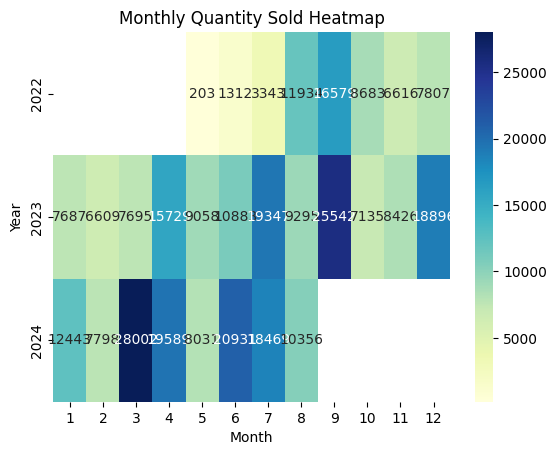

In [66]:
df['year'] = df.index.year
df['month'] = df.index.month

monthly_qty = df.resample('ME')['quantity'].sum().reset_index()
pivot = monthly_qty.pivot_table(values='quantity', index=monthly_qty['weekend_date'].dt.year, columns=monthly_qty['weekend_date'].dt.month)

sns.heatmap(pivot, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Monthly Quantity Sold Heatmap')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()


In [69]:
z_scores = np.abs(stats.zscore(weekly_sales))
anomalies = weekly_sales[z_scores > 3]
print("Potential anomalies:\n", anomalies)

Potential anomalies:
 weekend_date
2024-03-17    11816
2024-04-21     9236
Name: quantity, dtype: int64


In [70]:
weekly_sales_df = weekly_sales.reset_index()
weekly_sales_df.columns = ['date', 'weekly_sales']
weekly_sales_df.to_csv('clean_weekly_sales.csv', index=False)

In [ ]:
Key Insights

-->Dataset Overview:

-600 entries of weekly sales data from Jan 2022 to Sept 2023.
-Each row represents a transaction with fields: channel, brand, category, sub_category, SerialNum, and quantity.
-The datetime index was derived from SerialNum or existing date format.

-->Missing & Anomalies:

-No missing values, but some weeks show unusually high sales (e.g., March 17, April 21).
-Outliers may correspond to promotions or stockpiling events.

-->Trends & Seasonality:

-Clear weekly seasonality visible.
-Sales tend to spike intermittently — not following strict calendar events, suggesting potential promotions or market-driven anomalies.
-No strong monthly or quarterly seasonality, but periodic surges require attention.